<h1 align="center"> Practical Project 1 - Modelling of a 2-Step SAR-based ADC </h1>

<p align="justify">
    In this first project the goal is to develop an high-level model of a 2-step pipeline ADC based on sub SAR-ADCs. The sub ADCs feature loop-unrolling, using a comparator for each bit extraction in an assynchronous fashion for each successive bit, reducing the timing diagram of the SAR-ADCs to a single conversion period and a single reset period.
</p>

<h2 align="left"> Sub-ADC Operation </h2>
<p align="center">
    <img src="../docs/imgs/sub_adc_paper1.png" width=500>
</p>

<p align="justify">
The operation of the sub loop-unrolled SAR-ADC must be understood in order to proceed with the modelling activity. A few important notes can be taken from the figure above:

<ul align="left">

<il> 1 - The SAR-ADC uses an assynchronous comparator for the extraction of each bit (loop-unrolling technique) - not the classical architecture of a single comparator for all bits; </il>

<il> 2 - The differential architecture of the SAR-ADC enables to extract the Most Significant Bit for free right after sampling, without using the DAC capacitive arrays, using comparator D5; </il>

<il> 3 - The SAR-ADC is performing bottom-sampling to sample the input differential signal, and as such, the first step after sampling is encharged of transposing the input signal from the bottom plate to the top plate of the capacitors of the DAC array, where the comparators are connected to; </il>

<il> 4 - The capacitive DAC arrays feature a split-capacitor architecture, unfolding the capacitance of each element in half. This enables the split capacitor to have one of its bottom plates connected to VREF- and the other to VREF+ at all times during bit extraction - thus allowing the voltage at the top plate of the capacitor array to stay relatively stable around the common mode voltage VCM. The stability of the top plate voltage around VCM is very important to maintain the correct operation and operating point of the comparators D<5:0>.</il>

<il> 5 - After each bit decision, if the current bit is a logical "1", then the bottom plates of the corresponding positive(top)-array split-capacitor are connected to VREF+ / VREF-, and consequently the bottom plates of the corresponding negative(bottom)-array split-capacitor are connected to VREF- / VREF+, symmetrically. This will pull the top plate voltage of the positive capacitor array upwards, and pull the top plate voltage of the negative capacitor array downwards, adjusting the decision scale for each comparator. </il>



<il> If the current bit is decided to be a logical "0", then the symmetrical connections will be performed. In this case, the top plate voltage of the positive capacitor array will be pulled downwards, and the top plate voltage of the negative capacitor array will be pushed upwards, once again adjusting the decision scale for each comparator. </il> 
</ul>

<il> The last Cs capacitor, presenting the lowest weight of the array is also programmed! Usually, this capacitor is not programmed, but to enable pipeline operation, the Residue voltage must be available at the top plate of the </il>

Note that: bit D5 will influence the connections of the 8C+8C split capacitor (which decides bit D4); bit D4 will influence the connections of the 4C+4C split capacitor (which decides bit D3), and etc. ...

</p>

<h2 align="left"> Timing Diagram of sub SAR-ADC </h2>

<p align="center">
    <img src="../docs/imgs/sub_adc_paper1_timing_diagram.png" width=500 />
</p>

In [576]:
# set up required imports
from functools import partial
import pdb # python debugger

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

In [577]:
# setup the time base for the input signal
# number of simulation points
Np = 2**15
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)

In [578]:
# setup the ADC parameters
vdd     = 1.0
vss     = 0.0
vcm     = np.mean([vdd, vss])
vref    = vdd   # reference voltage of the whole 2-step adc

# first sub ADC
vref_first      = vref
vrefp_first     = vcm + vref_first/2
vrefn_first     = vcm - vref_first/2
Nbits_first     = 6
vlsb_first      = vref_first/(2**Nbits_first)

# second sub ADC
vref_second     = vref/4
vrefp_second    = vcm + vref_second/2
vrefn_second    = vcm - vref_second/2
Nbits_second    = 6
vlsb_second     = vref_second/(2**Nbits_second)

In [579]:
# scales
# volts 
V   = 1.0
mV  = V*1e-3
uV  = V*1e-6
nV  = V*1e-9

# seconds
s  = 1.0
ms = s*1e-3
us = s*1e-6
ns = s*1e-9

# frequency
Hz = 1.0
kHz = Hz*1e3
MHz = Hz*1e6
GHz = Hz*1e9

# length
m  = 1.0
mm = m*1e-3
um = m*1e-6
nm = m*1e-9

# farad
F  = 1.0
pF = F*1e-12
fF = F*1e-15

### ENABLE NOISE SIMULATION

In [580]:
ENABLE_NOISE = False # enable noise supperposed to the input signal
vn_mean = 0.0*V     # mean of the noise signal
vn_std  = 1*mV    # standard deviation of the noise signal
vn_in   = normal(vn_mean, vn_std, Np) # generate the gaussian/white (random) noise signal

In [581]:
# observe the noise signal
if ENABLE_NOISE:
    fig, ax = plt.subplots(figsize=(4,3))
    sns.histplot(vn_in, ax=ax, kde=True, stat='probability', color='gray', label='noise signal')
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Probability density')
    ax.set_title('Histogram of the noise signal')
    plt.show()

# Sub SAR-ADC transfer function

<p align="justify">
The general analog to digital transfer function Dout(Vin) of the sub SAR-ADC can be derived using the charge conservation principle (CCP) to derive the voltage at the top plate of the capacitor arrays in each step of the conversion process.

There are two main approaches: the long form, that actually describes the true operation of the capacitor arrays, or the short form, simplifying the analysis regarding the modelling of the capacitor arrays when writting the code.

<ul>

<il> The long form implies applying the CCP to the sampling phase and each of the corresponding phases of each extracted bit, taking into account all the capacitors connected to each array;</il>

<il>The short form implies applying the CCP to each pair of successive phases of each bit extraction, taking only into account the capacitance associated to the changed bottom plate connections.</il>

</ul>

</p>

In [582]:
# setup the input signal of the first sub ADC
A1      = vref
fbin    = 1
f1      = fbin*(Fs/Np)
ph1    = 0
vin1t   = A1*np.sin(2*np.pi*f1*tD + ph1)
if ENABLE_NOISE:
    vin1t = vin1t + vn_in

# compute the spectrum of the input signal
vin1f           = np.abs(np.fft.fftshift(np.fft.fft(vin1t) / Np))  # [V] # voltage in the frequency axis
# NOTE: fft(yf) is divided by Np in order to normalize the resulting frequency spectrum from the digital fourier transform
fD              = np.fft.fftshift(np.fft.fftfreq(Np, Ts))  # [Hz] # frequency axis
power_vin1f     = (vin1f*vin1f) # [V^2] - square the voltage spectrum to obtain the power spectrum
power_vinf_dB   = 10 * np.log10(power_vin1f)  # [dB] - convert the power spectrum to dB


In [583]:
# setup the input voltage array
vin1    = np.sort(np.unique(vin1t)) 
vint_p  = (vin1t)/2 + vcm
vint_n  = -(vin1t)/2 + vcm
vinp    = (vin1)/2 + vcm
vinn    = -(vin1)/2 + vcm

(29416, 29416)

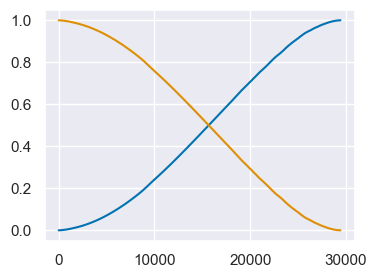

In [584]:
# show the unique values of the input signal
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(vinp, label='input signal')
ax.plot(vinn, label='input signal')

len(vinp), len(vinn)

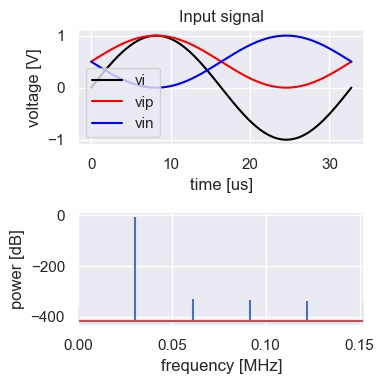

In [585]:
# observe the input signal in time and frequency
fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(tD/us, vin1t, label='vi', color='black')
ax[0].plot(tD/us, vint_p, label='vip', color='red')
ax[0].plot(tD/us, vint_n, label='vin', color='blue')
ax[0].legend()
ax[0].set_xlabel('time [us]')
ax[0].set_ylabel('voltage [V]')
ax[0].set_title('Input signal')
ax[0].grid(True)
ax[1].stem(
    fD[fD>=0]/MHz, 
    power_vinf_dB[fD>=0], 
    label='input signal in frequency', 
    bottom=np.min(power_vinf_dB), 
    linefmt="b-",
    markerfmt="none",
    basefmt="r-"
)
ax[1].grid(True)
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('power [dB]')
# close up on the frequency axis
ax[1].set_xlim([0, 5*f1/MHz])
plt.tight_layout()
plt.show()

In [586]:
# setup mponte carlo analysis
Ncircuits = 100 # number of circuits in monte carlo simulation

first_sub_adc_avg_lin = [] 

# setup comparator offset
Num_comp_offsets    = 1    # number of comparator offsets to be simulated
comp_offsets        = np.linspace(0, 5*mV, Num_comp_offsets) # [V] # array of comparator offsets

# setup the capacitor mismatch error for the monte carlo sim
cap_err_mean    = 0.0
cap_mismatch    = 0.05  # 5% capacitor mismatch
std_cap_err     = cap_mismatch

#vin1 = np.array([1.0])
#vinp = (vin1)/2 + vcm
#vinn = -(vin1)/2 + vcm

for comp_offset in comp_offsets:
    first_sub_adc_lins = []
    for _ in range(Ncircuits):
        
        """ FIRST STAGE:
            SUB-ADC based on a VCM-based fully differential 
            splitted capacitor DAC SAR-ADC
        """
        
        # setup the splitted capacitor DAC arrays
        # NOTE: number of capacitors in each array, considering a splitted capacitor DAC with a monotonic SAR algorithm
        Num_caps_array      = Nbits_first - 2
        # number of unitary capacitors in to generate the binary weighted capacitor array
        Num_unit_caps_array = 2**Num_caps_array
        
        # positive array
        # generate the unitary capacitor array
        # even indexes
        cap_err_even    = normal(cap_err_mean, std_cap_err, Num_unit_caps_array) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_even))*(1 + cap_err_even) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        pos_cap_even    = np.array(
            [unittary_caps[-1]]+
            [ np.sum(unittary_caps[2**b - 1: 2**(b+1)-1]) 
            for b in range(Num_caps_array) ]) # [F]
        # odd indexes
        cap_err_odd     = normal(cap_err_mean, std_cap_err, Num_unit_caps_array) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_odd))*(1 + cap_err_odd) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        pos_cap_odd     = np.array(
            [unittary_caps[-1]]+
            [ np.sum(unittary_caps[ 2**b -1: 2**(b+1)-1 ]) 
            for b in range(Num_caps_array) ]) # [F] 
        
        # negative array
        # generate the unitary capacitor array
        # even indexes
        cap_err_even    = normal(cap_err_mean, std_cap_err, Num_unit_caps_array) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_even))*(1 + cap_err_even) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        neg_cap_even    = np.array(
            [unittary_caps[-1]]+
            [ np.sum(unittary_caps[2**b -1 : 2**(b+1)-1]) 
            for b in range(Num_caps_array) ]) # [F]
        # odd indexes
        cap_err_odd     = normal(cap_err_mean, std_cap_err, 2**(Nbits_first-2)) # [F] # capacitor mismatch error
        unittary_caps   = np.ones(len(cap_err_odd))*(1 + cap_err_odd) # [F] # array of unitary capacitors
        # generate the binary weighted capacitor array
        neg_cap_odd     = np.array(
            [unittary_caps[-1]]+
            [ np.sum(unittary_caps[ 2**b - 1: 2**(b+1)-1 ]) 
            for b in range(Num_caps_array) ]) # [F]
        
        # put heavier capacitors at the beginning of the array
        pos_cap_even = pos_cap_even[::-1]
        pos_cap_odd = pos_cap_odd[::-1]
        neg_cap_even = neg_cap_even[::-1]
        neg_cap_odd = neg_cap_odd[::-1]
        
        # after setting up the capacitor arrays, perform charge redistribution phases
        
        # setup the comparator array
        vcomps_err  = normal(0, comp_offset, Nbits_first) # [V] # comparator offset error
        #vcomps      = vcm*np.ones(Nbits_first)*(1 + vcomps_err) # [V] # array of comparators
        vcomps = vcomps_err
        
        
        # NOTE: This algorithm can be performed by means 
        # of a for loop, but in here we are using 
        # a vectorized implementation for the sake of 
        # simulation speed
        
        # setup the node voltage at vp and vn
        # There will be :
        # a ) the first node voltage corresponding 
        # to the end of the bot-plate sampling phase,
        # b ) then there will be a node voltage for each bit conversion
        # c ) and finally there will be a node voltage 
        # corresponding to the sampling of the residue voltage
        # Giving Nbits + 2 conversion steps in total for the 
        # sub-ADC of the first stage
        vp = np.zeros((Nbits_first+2, len(vinp))) # [V] # node voltage at the positive array
        vn = np.zeros((Nbits_first+2, len(vinn))) # [V] # node voltage at the negative array
            
        # setup the charge at the positive and negative arrays in each decision phase
        charge_p  = np.zeros((len(vp), len(vinp))) # [C] # charge at the positive array
        charge_n  = np.zeros((len(vn), len(vinn))) # [C] # charge at the negative array
            
        pos_total_cap   = np.sum(pos_cap_even) + np.sum(pos_cap_odd) # [F] # total capacitance of the positive array
        neg_total_cap   = np.sum(neg_cap_even) + np.sum(neg_cap_odd) # [F] # total capacitance of the negative array
            
        # bottom-plate sampling phase
        vp[0,:] = vcm # [V] # bottom plate sampling phase
        vn[0,:] = vcm # [V] # bottom plate sampling phase
        charge_p[0,:]   = (vp[0, :]-vinp)*pos_total_cap # [C] # charge at the positive array
        charge_n[0,:]   = (vn[0, :]-vinn)*neg_total_cap # [C] # charge at the negative array
        
        dout        = np.zeros((Nbits_first, len(vinp))) # [V] # digital output of the first sub ADC
        dout_neg    = np.zeros((Nbits_first, len(vinp))) # [V] # digital output of the first sub ADC
        
        # NOTE: THE COMMENTED STEPS BELOW ARE INCLUDED IN THE FOR LOOP BELOW
        # parse the charge from the bottom plate to the top plate
        # of each capacitor in the positive and negative array
        #vp[1, :] = charge_p[0, :]/pos_total_cap + vrefp_first*np.sum(pos_cap_odd)/pos_total_cap + vrefn_first*np.sum(pos_cap_even)/pos_total_cap # [V] # top plate sampling phase
        #vn[1, :] = charge_n[0, :]/neg_total_cap + vrefp_first*np.sum(neg_cap_odd)/neg_total_cap + vrefn_first*np.sum(neg_cap_even)/neg_total_cap # [V] # top plate sampling phase
        
        #charge_p[1, :]  = (vp[1, :] - vrefp_first)*np.sum(pos_cap_odd) + (vp[1, :] - vrefn_first)*np.sum(pos_cap_even) # [C] # charge at the positive array
        #charge_n[1, :]  = (vn[1, :] - vrefp_first)*np.sum(neg_cap_odd) + (vn[1, :] - vrefn_first)*np.sum(neg_cap_even) # [C] # charge at the negative array
        
        # we don't use the DAC for the first bit decision
        #dout[0, :]      = vp[1, :]-vn[1, :] > (vcomps[0]-vcm)  # [V] # digital output of the first sub ADC
        #dout_neg[0, :]  = 1-dout[0, :]
        
        ## ! CONVERSION STEPS PHASE BETWEEN THE FIRST (MOST SIGNIFICANT BIT - MSB) AND THE SECOND-TO-LAST BITS ##
        
        # conversion step phases (decision phases) of the first sub ADC
        for k in range(0, Nbits_first-1):
            # positive array
            # capacitors connected to the positive reference
            cap_vrefp_pos = np.sum(pos_cap_odd[k:]) + \
                dout[:-2,:].T @ pos_cap_even[:-1].reshape(-1, 1) + \
                dout[:-2,:].T @ pos_cap_odd[:-1].reshape(-1, 1)
            # capacitors connected to the negative reference
            cap_vrefn_pos = np.sum(pos_cap_even[k:]) + \
                dout_neg[:-2,:].T @ pos_cap_even[:-1].reshape(-1, 1) + \
                dout_neg[:-2,:].T @ pos_cap_odd[:-1].reshape(-1, 1)
            
            cap_vrefp_pos = cap_vrefp_pos.T
            cap_vrefn_pos = cap_vrefn_pos.T
            
            vp[k+1, :] = (charge_p[k, :] + vrefp_first*cap_vrefp_pos + vrefn_first*cap_vrefn_pos)/pos_total_cap # [V] # top plate sampling phase
            charge_p[k+1, :] = (vp[k+1, :] - vrefp_first)*cap_vrefp_pos + (vp[k+1, :] - vrefn_first)*cap_vrefn_pos # [C] # charge at the positive array
            
            # negative array
            # capacitors connected to the positive reference
            cap_vrefp_neg = np.sum(neg_cap_odd[k:]) + \
                dout_neg[:-2,:].T @ neg_cap_even[:-1].reshape(-1, 1) + \
                dout_neg[:-2,:].T @ neg_cap_odd[:-1].reshape(-1, 1)
            # capacitors connected to the negative reference
            cap_vrefn_neg = np.sum(neg_cap_even[k:]) + \
                dout[:-2,:].T @ neg_cap_even[:-1].reshape(-1, 1) + \
                dout[:-2,:].T @ neg_cap_odd[:-1].reshape(-1, 1)
            
            cap_vrefp_neg = cap_vrefp_neg.T
            cap_vrefn_neg = cap_vrefn_neg.T
            
            vn[k+1, :] = (charge_n[k, :] + vrefp_first*cap_vrefp_neg + vrefn_first*cap_vrefn_neg)/neg_total_cap # [V] # top plate sampling phase
            charge_n[k+1, :] = (vn[k+1, :] - vrefp_first)*cap_vrefp_neg + (vn[k+1, :] - vrefn_first)*cap_vrefn_neg # [C] # charge at the negative array
            
            # decide the digital output of the first sub ADC
            dout[k, :]      = vp[k+1, :]-vn[k+1, :] < vcomps[k]  # [V] # digital output of the first sub ADC
            dout_neg[k, :]  = 1-dout[k, :]
            
            #if k == Nbits_first-2: pdb.set_trace()
        #####################################################
        # In this model, the LSB capacitor is the last capacitor
        # of the even capacitor arrays for both the negative and 
        # positive arrays, while the Residue Sampling capacitor
        # is the last capacitor of the odd capacitor arrays 
        # for both the negative and positive arrays.
        
        
        ##! LEAST SIGNIFICANT BIT CONVERSION ##
        
        # convert the last bit = Least Significant Bit (LSB)
        # During the extraction of the LSB, only one capacitor 
        # of each DAC array commutes between VREFP and VREFN, once
        # the LSB capacitor is not splitted in half.
        
        #k = Nbits_first-1
        k += 1
        # connect the LSB cap of the positive array to VREFP 
        # if the fifth bit is HIGH (1)
        # don't forget to add the residue cap
        cap_vrefp_pos = pos_cap_odd[-1] + \
            dout[:-1,:].T @ pos_cap_even.reshape(-1, 1) + \
            dout[:-2,:].T @ pos_cap_odd[:-1].reshape(-1, 1)
        # connect the LSB cap of the positive array to VREFN 
        # if the fifth bit is LOW (0),
        cap_vrefn_pos = dout_neg[:-1,:].T @ pos_cap_even.reshape(-1, 1) + \
            dout_neg[:-2,:].T @ pos_cap_odd[:-1].reshape(-1, 1)
        
        cap_vrefp_pos = cap_vrefp_pos.T
        cap_vrefn_pos = cap_vrefn_pos.T
        
        vp[k+1, :] = (charge_p[k, :] + vrefp_first*cap_vrefp_pos + vrefn_first*cap_vrefn_pos)/pos_total_cap # [V] # top plate sampling phase
        charge_p[k+1, :] = (vp[k+1, :] - vrefp_first)*cap_vrefp_pos + (vp[k+1, :] - vrefn_first)*cap_vrefn_pos # [C] # charge at the positive array
        
        # negative array
        # connect the LSB cap of the negative array to VREFP 
        # if the fifth bit is LOW (0)
        # don't forget to add the residue cap
        cap_vrefp_neg = neg_cap_odd[-1] + \
            dout_neg[:-1,:].T @ neg_cap_even.reshape(-1, 1) + \
            dout_neg[:-2,:].T @ neg_cap_odd[:-1].reshape(-1, 1)
        
        # connect the LSB cap of the negative array to VREFN 
        # if the fifth bit is HIGH (1),
        cap_vrefn_neg = dout[:-1,:].T @ neg_cap_even.reshape(-1, 1) + \
            dout[:-2,:].T @ neg_cap_odd[:-1].reshape(-1, 1)
        
        cap_vrefp_neg = cap_vrefp_neg.T
        cap_vrefn_neg = cap_vrefn_neg.T
        
        vn[k+1, :] = (charge_n[k, :] + vrefp_first*cap_vrefp_neg + vrefn_first*cap_vrefn_neg)/neg_total_cap # [V] # top plate sampling phase
        charge_n[k+1, :] = (vn[k+1, :] - vrefp_first)*cap_vrefp_neg + (vn[k+1, :] - vrefn_first)*cap_vrefn_neg # [C] # charge at the negative array
        
        # decide the digital output of the first sub ADC
        dout[k, :]      = vp[k+1, :]-vn[k+1, :] < vcomps[k]  # [V] # digital output of the first sub ADC
        dout_neg[k, :]  = 1-dout[k, :]
        
        
        ##! RESIDUE VOLTAGE SAMPLING ##
        # Finally, sample the resiude at the last capacitor of the odd cap array
        # and thus, enabling pipelining between both stages of the 2-step ADC with
        # VCM-based sub-SAR ADCs
        
        k += 1
        # connect the residue cap of the positive array to VREFP 
        # if the fifth bit is HIGH (1)
        cap_vrefp_pos = dout[:-1,:].T @ pos_cap_even.reshape(-1, 1) + \
            dout[:-1,:].T @ pos_cap_odd.reshape(-1, 1)
        # connect the residue cap of the positive array to VREFN 
        # if the fifth bit is LOW (0),
        cap_vrefn_pos = dout_neg[:-1,:].T @ pos_cap_even.reshape(-1, 1) + \
            dout_neg[:-1,:].T @ pos_cap_odd.reshape(-1, 1)
        
        cap_vrefp_pos = cap_vrefp_pos.T
        cap_vrefn_pos = cap_vrefn_pos.T
        
        vp[k+1, :] = (charge_p[k, :] + vrefp_first*cap_vrefp_pos + vrefn_first*cap_vrefn_pos)/pos_total_cap # [V] # top plate sampling phase
        charge_p[k+1, :] = (vp[k+1, :] - vrefp_first)*cap_vrefp_pos + (vp[k+1, :] - vrefn_first)*cap_vrefn_pos # [C] # charge at the positive array
        
        # negative array
        # connect the residue cap of the negative array to VREFP 
        # if the fifth bit is LOW (0)
        cap_vrefp_neg = dout_neg[:-1,:].T @ neg_cap_even.reshape(-1, 1) + \
            dout_neg[:-1,:].T @ neg_cap_odd.reshape(-1, 1)
        
        # connect the LSB cap of the negative array to VREFN 
        # if the fifth bit is HIGH (1),
        cap_vrefn_neg = dout[:-1,:].T @ neg_cap_even.reshape(-1, 1) + \
            dout[:-1,:].T @ neg_cap_odd.reshape(-1, 1)
        
        cap_vrefp_neg = cap_vrefp_neg.T
        cap_vrefn_neg = cap_vrefn_neg.T
        
        # compute the residue voltage at the VN node
        vn[k+1, :] = (charge_n[k, :] + vrefp_first*cap_vrefp_neg + vrefn_first*cap_vrefn_neg)/neg_total_cap # [V] # top plate sampling phase
        charge_n[k+1, :] = (vn[k+1, :] - vrefp_first)*cap_vrefp_neg + (vn[k+1, :] - vrefn_first)*cap_vrefn_neg # [C] # charge at the negative array
        
        ##############################################
        
        # convert the digital output of the first sub ADC to a decimal number
        dout_dec_first = bin2dec(dout.T, width=Nbits_first, reverse=False)
        # get the transistion voltage of the first sub ADC
        dout_first = dout_dec_first[ np.where(np.diff(dout_dec_first) != 0 )[0] ]
        vtrans_first = vin1[ np.where(np.diff(dout_dec_first) != 0 )[0] ]
        #pdb.set_trace()
        
        # compute the INL and DNL of the first sub ADC
        vlsb_measured = (vtrans_first[-1] - vtrans_first[0])/(2**Nbits_first - 2)
        dnl_first = np.diff(vtrans_first)/vlsb_measured - 1
        inl_first = np.array([0] + np.cumsum(dnl_first).tolist())
        assert len(dnl_first) == 2**Nbits_first - 2, 'DNL length is not correct: {}'.format(len(dnl_first))
        assert len(inl_first) == 2**Nbits_first - 1, 'INL length is not correct: {}'.format(len(inl_first))
        # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the
        # difference between the minimum and maximum value of the INL)
        adc_linearity = Nbits_first - np.log2(np.max(inl_first) - np.min(inl_first))
        first_sub_adc_lins.append(adc_linearity)
        
        # compute the residual voltage of the first sub ADC
        vres_first = vp[-1, :] - vn[-1, :] # [V] # residual voltage of the first sub ADC
        # inspect the residue voltage at each digital output code transition
        vres_first_trans = vres_first[ np.where(np.diff(dout_dec_first) != 0 )[0] ]
        
        """ RESIDUE AMPLIFIER:
            SUB-ADC based on a VCM-based fully differential 
            splitted capacitor DAC SAR-ADC
        """
        
        """ SECOND STAGE:
            SUB-ADC based on a VCM-based fully differential 
            splitted capacitor DAC SAR-ADC
        """
        
        
    first_sub_adc_avg_lin.append(np.mean(first_sub_adc_lins))


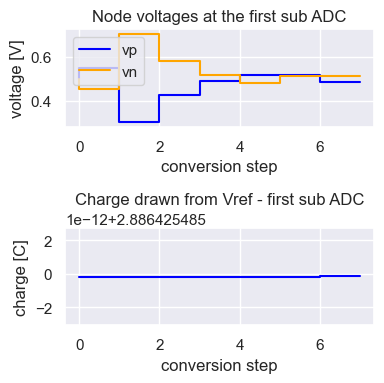

In [587]:
# observe the voltages at the vp and vn nodes of the first sub ADC in each conversion step
fig, ax = plt.subplots(2,1,figsize=(4,4))
#vin = vtrans_first[len(vtrans_first)//2]
idx = len(vp[0, :])//2
#idx = 0
ax[0].step(list(range(len(vp))),vp[:, idx ], label='vp', color='blue', where="pre")
ax[0].step(list(range(len(vn))),vn[:, idx ], label='vn', color='orange', where="pre")
# plot the input voltage in the same plot to observe the evolution of the voltage at the vp and vn nodes

# observe the charge at the end of each conversion step
ax[1].step(list(range(len(charge_p))),charge_p[:, idx ]-charge_n[:, idx], label='charge drawn from vref', color='blue', where="pre")
ax[0].set_xlabel('conversion step')
ax[0].set_ylabel('voltage [V]')
ax[0].set_title('Node voltages at the first sub ADC')
ax[0].grid(True)
ax[0].legend()
ax[1].set_xlabel('conversion step')
ax[1].set_ylabel('charge [C]')
ax[1].set_title('Charge drawn from Vref - first sub ADC')
ax[1].grid(True)
plt.tight_layout()

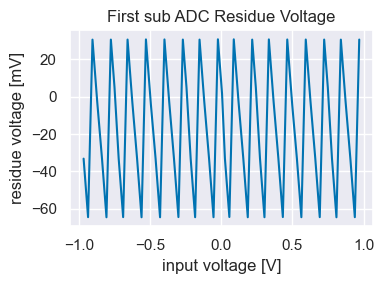

In [588]:
# observe the residue voltage of the virst sub SAR-ADC 
# agains the input voltage of the ADC
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(vtrans_first, vres_first_trans/mV)
ax.set_xlabel('input voltage [V]')
ax.set_ylabel('residue voltage [mV]')
ax.set_title('First sub ADC Residue Voltage')
ax.grid(True)
plt.tight_layout()

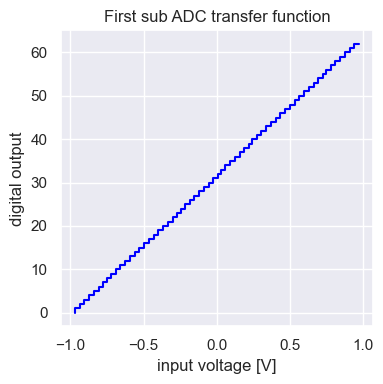

In [589]:
# plot the transfer function of the first sub ADC
fig, ax = plt.subplots(figsize=(4,4))
ax.step(vtrans_first, dout_first, label='first sub ADC transfer function', color='blue')
# plot the maximum and minimum of the inl to observe the error 
# margins and inspect the linearity of the ADC visually

ax.set_xlabel('input voltage [V]')
ax.set_ylabel('digital output')
ax.set_title('First sub ADC transfer function')
ax.grid(True)
plt.tight_layout()

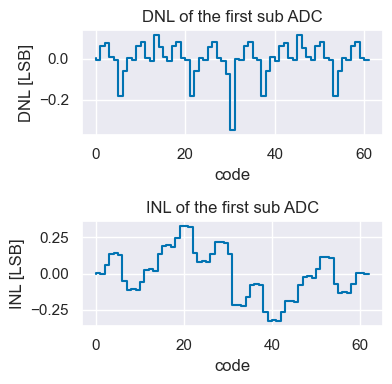

In [590]:
# plot the INL and DNL of the first sub ADC
fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].step(dout_first[:-1], dnl_first, label='DNL')
ax[0].set_xlabel('code')
ax[0].set_ylabel('DNL [LSB]')
ax[0].set_title('DNL of the first sub ADC')
ax[0].grid(True)
ax[1].step(dout_first, inl_first, label='INL')
ax[1].set_xlabel('code')
ax[1].set_ylabel('INL [LSB]')
ax[1].set_title('INL of the first sub ADC')
ax[1].grid(True)
plt.tight_layout()

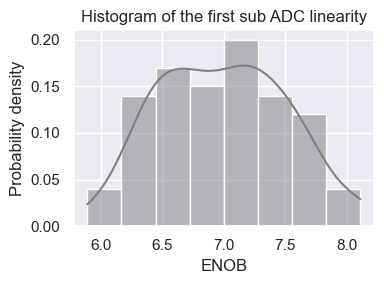

In [591]:
# plot the linearity histogram of the first sub ADC
fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(first_sub_adc_lins, ax=ax, 
             kde=True, stat='probability', 
             color='gray', 
             label='first sub ADC linearity')
ax.set_xlabel('ENOB')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of the first sub ADC linearity')
plt.tight_layout()

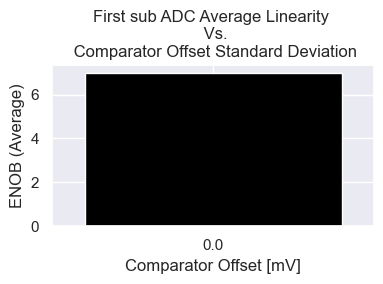

In [592]:
# observe the average linearity of the first sub ADC 
# against comparator offset
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(x=comp_offsets/mV, y=first_sub_adc_avg_lin, color='black', ax=ax)
ax.set_xlabel('Comparator Offset [mV]')
ax.set_ylabel('ENOB (Average)')
ax.set_title('First sub ADC Average Linearity \n Vs.\n Comparator Offset Standard Deviation')
ax.grid(True)
plt.tight_layout()